# Livewire segmentation algorithm

In this notebook, we want to reproduce Livewire algorithm and compute the shortest path between two clicks.

We will need an implementation of Dijkstra's shortest path algorithm (dijkstra.py) and an example DICOM slice image.

If you are in a hurry, execute the whole notebook and scroll back to the last line!

# Input
Read a DICOM slice image from file, convert it to a numpy array (http://www.osirix-viewer.com/datasets/). There is a number of freely available DICOM images online.

In [1]:
import skimage

In [2]:
import dicom

df = dicom.read_file('../images/lung.dcm')
image = skimage.img_as_uint(df.pixel_array)

/Library/Python/2.7/site-packages/skimage/util/dtype.py:103: UserWarning: Possible sign loss when converting negative image of type int16 to positive image of type uint16.
  "%s to positive image of type %s." % (dtypeobj_in, dtypeobj))
/Library/Python/2.7/site-packages/skimage/util/dtype.py:107: UserWarning: Possible precision loss when converting from int16 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


In the commented out section we demonstrate that Livewire segmentation is not limited to medical images and can be applied without modification to other images, e.g. photos.

In [3]:
#from skimage import data
#image = skimage.data.lena()

In [4]:
#from skimage import color
#image = color.rgb2gray(image)

In [5]:
from skimage import io
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
plt.gray()

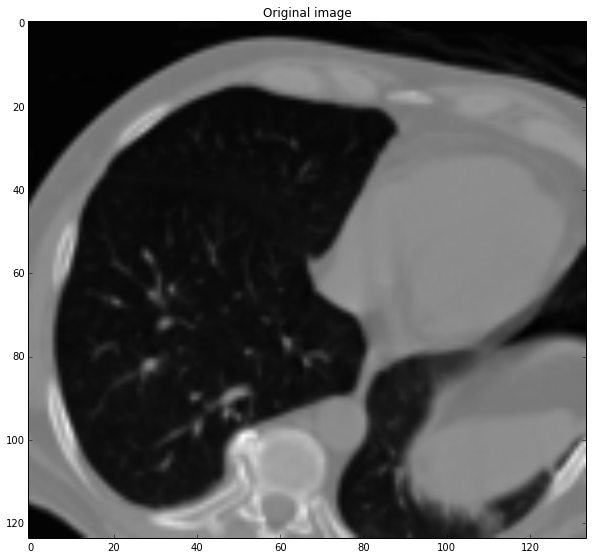

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.title('Original image')

# Reduce image noise

http://scikit-image.org/docs/dev/auto_examples/filters/plot_denoise.html

In [7]:
from skimage import restoration

In [8]:
denoised_image = restoration.denoise_bilateral(image)

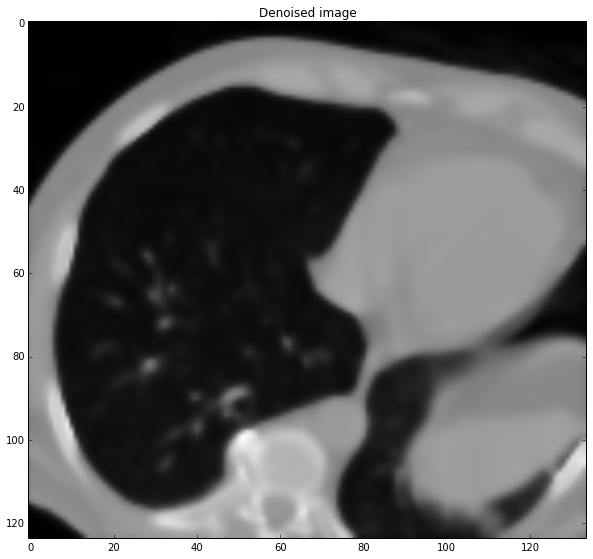

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(denoised_image)
plt.title('Denoised image')

# Compute gradient image 

To achieve more stable segmentation, the gradient image is thresholded. By doing so, we eliminate value differences along the boundaries, thus encouraging the algorithm to stay on the boundary until the user clicks outside of it. Scharr gradient filter has proven to deliver most sharp gradient image than Sobel operator.

Also see: http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.sobel.

In [10]:
from skimage import filters

In [11]:
edges = filters.scharr(image)

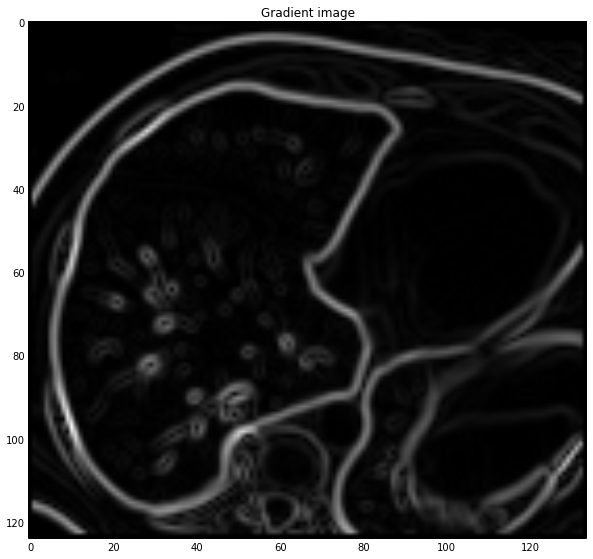

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(edges)
plt.title('Gradient image')

In [13]:
from skimage.filters import threshold_otsu

threshold = threshold_otsu(edges)
edges_thresholded = edges > threshold
edges = edges_thresholded

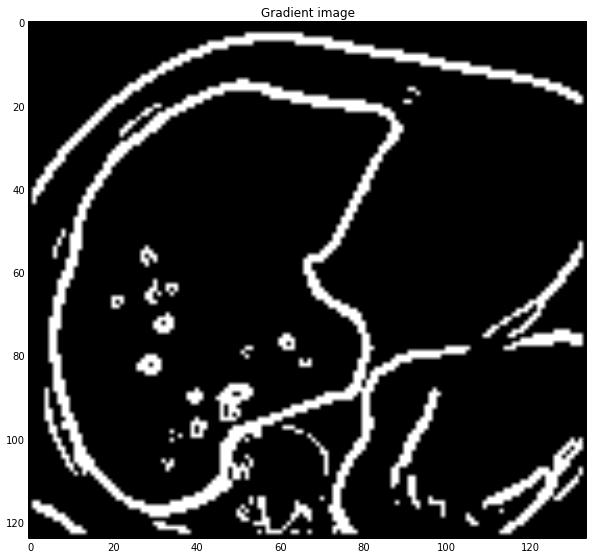

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(edges_thresholded)
plt.title('Gradient image')

# Compare images

We display images next to each other for direct comparison.

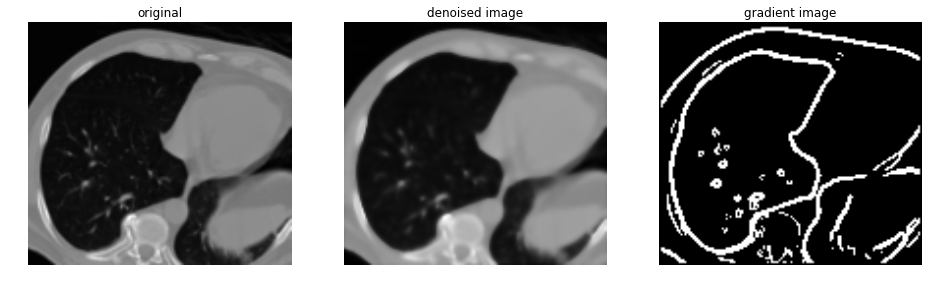

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 10), sharex=True,
                       sharey=True, subplot_kw={'adjustable': 'box-forced'})

plt.gray()

ax[0].imshow(image, cmap=pylab.cm.gray)
ax[0].axis('off')
ax[0].set_title('original')
ax[1].imshow(denoised_image, cmap=pylab.cm.gray)
ax[1].axis('off')
ax[1].set_title('denoised image')
ax[2].imshow(edges, cmap=pylab.cm.gray)
ax[2].axis('off')
ax[2].set_title('gradient image')

# Convert gradient image into a graph
Use the dictionary representation of a graph (https://www.python.org/doc/essays/graphs/)

In [16]:
from math import fabs

G = {}
rows, cols = edges.shape
for col in range(cols):
    for row in range(rows):
        
        neighbors = []
        if row > 0:
            neighbors.append( (row-1, col) )
        
        if row < rows-1:
            neighbors.append( (row+1, col) )
            
        if col > 0:
            neighbors.append( (row, col-1) )
        
        if col < cols-1:
            neighbors.append( (row, col+1) )
        
        dist = {}
        for n in neighbors:
            # distance function can be replaced with a different norm
            dist[n] = fabs(edges[row][col] - edges[n[0], n[1]])
            
        G[(row,col)] = dist

# Compute shortest path
Re-use Dijkstra algorithm (http://code.activestate.com/recipes/119466-dijkstras-algorithm-for-shortest-paths/). The solution from the comment has been taken, since it is much faster than the original code.

In the pop-up window, left-click once to set the starting point for the segmentation. If you enable INTERACTIVE mode, then you will see suggestions as you move you mouse around. Left-click again, to set the next point. You cannot modify the contour once the next point has been set. Pressing ESCAPE on the keyboard closes one contour. After that, you can segment another structure.

In [17]:
from dijkstra import shortestPath

In [18]:
%matplotlib 
INTERACTIVE = True
from itertools import cycle
import numpy as np
COLORS = cycle('rgbyc')

start_point = None
current_color = COLORS.next()
current_path = None
length_penalty = 10.0

def button_pressed(event):
    global start_point
    if start_point is None:
        start_point = (int(event.ydata), int(event.xdata))
        
    else:
        end_point = (int(event.ydata), int(event.xdata))
        path = shortestPath(G, start_point, end_point, length_penalty=length_penalty)
        plt.plot(np.array(path)[:,1], np.array(path)[:,0], c=current_color)
        start_point = end_point

def mouse_moved(event):
    if start_point is None:
        return
    
    end_point = (int(event.ydata), int(event.xdata))
    path = shortestPath(G, start_point, end_point, length_penalty=length_penalty)
    
    global current_path
    if current_path is not None:
        current_path.pop(0).remove()
    current_path = plt.plot(np.array(path)[:,1], np.array(path)[:,0], c=current_color)

def key_pressed(event):
    if event.key == 'escape':
        global start_point, current_color
        start_point = None
        current_color = COLORS.next()

        global current_path
        if current_path is not None:
            current_path.pop(0).remove()
            current_path = None
            plt.draw()

plt.connect('button_release_event', button_pressed)
if INTERACTIVE:
    plt.connect('motion_notify_event', mouse_moved)
plt.connect('key_press_event', key_pressed)

plt.imshow(image)
plt.autoscale(False)
plt.title('Livewire example')
plt.show()

Using matplotlib backend: MacOSX


# That's it folks! 
Send your comments to https://github.com/pdyban/livewire.